# Sentinel-2 image matching

## Dataset Preparation

The dataset consists of organized directories containing information about the dates and locations of .jp2 images. Additionally, there is a GeoJSON file that holds information about vector shapes of certain objects at these locations. We will utilize the data from the GeoJSON file to identify key points within the images.

In [1]:
import numpy as np 
import pandas as pd
import geopandas as gpd

import rasterio
from rasterio.plot import reshape_as_image
from rasterio.features import rasterize

from shapely.geometry import mapping, Point, Polygon
from shapely.ops import cascaded_union

import matplotlib.pyplot as plt

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


### Visualizing the Vector Object Mask

We will visualize the mask of vector objects to gain insights into their spatial distribution. Additionally, we will examine the pixel values associated with these objects to facilitate further filtering processes.

In [2]:
# rasterize works with polygons that are in the image coordinate system
def poly_from_utm(polygon, transform):
    # create a polygon from multipolygon
    poly = cascaded_union(polygon)    
    # transform each polygon to image CRS, using raster metadata
    poly_pts = [~transform * tuple(i) for i in np.array(poly.exterior.coords)]
    return Polygon(poly_pts)

def visualize_mask(raster_path, geodf):
    with rasterio.open(raster_path, "r", driver='JP2OpenJPEG') as src:
        raster_image = src.read()
        raster_meta = src.meta
    # use EPSG:4236 for tiles from this dataset
    geodf.crs = {'init': 'epsg:4236'}
    # transforming polygons to the raster CRS
    geodf = geodf.to_crs({'init': raster_meta['crs']['init']})
    # creating a binary mask
    poly_shp = []
    im_size = (src.meta['height'], src.meta['width'])
    for num, row in geodf.iterrows():
        if row['geometry'].geom_type == 'Polygon':
            poly_shp.append(poly_from_utm(row['geometry'], src.meta['transform']))
        else:
            for p in row['geometry']:
                poly_shp.append(poly_from_utm(p, src.meta['transform']))
    mask = rasterize(shapes=poly_shp, out_shape=im_size)

    plt.figure(figsize=(12, 12))
    plt.imshow(mask, cmap='plasma')  # Apply a color spectrum from purple to yellow
    plt.colorbar(label="Mask value")  # Add a color scale on the right
    plt.show()


/opt/conda/lib/python3.7/site-packages/pyproj/crs/crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/opt/conda/lib/python3.7/site-packages/pyproj/crs/crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipyker

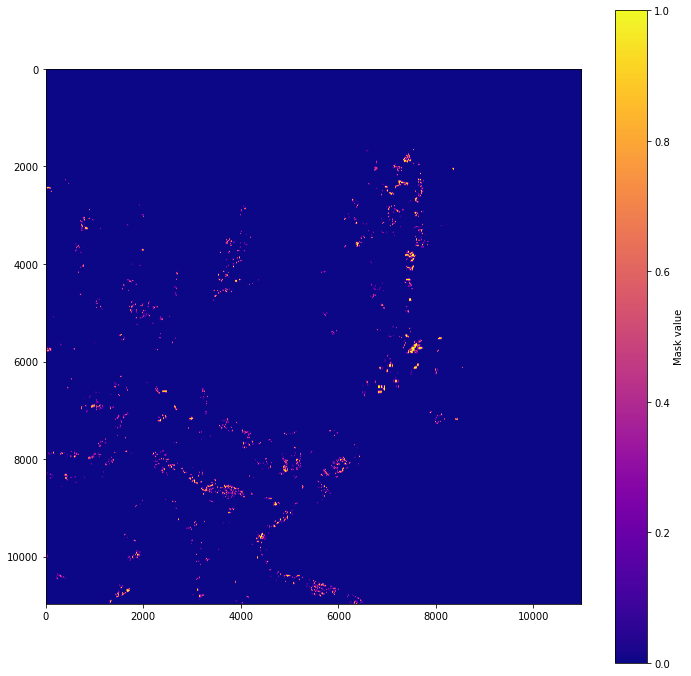

In [3]:
RASTER_PATH = '/kaggle/input/deforestation-in-ukraine/S2B_MSIL1C_20190611T083609_N0207_R064_T36UYA_20190611T122426/S2B_MSIL1C_20190611T083609_N0207_R064_T36UYA_20190611T122426.SAFE/GRANULE/L1C_T36UYA_A011816_20190611T084501/IMG_DATA/T36UYA_20190611T083609_TCI.jp2'
gdf = gpd.read_file('/kaggle/input/deforestation-in-ukraine/deforestation_labels.geojson')
visualize_mask(RASTER_PATH,gdf)

### Dataset Preparation for Key Object Detection

Next, we will focus on preparing the dataset for our specific task, which involves identifying key objects for pairs of images. To train the model effectively, we need a dataset consisting of pairs of images. We will establish pairs of images that correspond to the same locations but were captured on different dates. This approach is essential for addressing variations across different seasons. Additionally, we will consider different spectral filters, as various ranges may introduce distinct artifacts that need to be managed during the analysis.

In [4]:
import re
import json
from pathlib import Path
import os

In [5]:
dataset_path = Path("/kaggle/input/deforestation-in-ukraine")

# Function to extract date, location, and spectrum from the path
def parse_image_path(image_path):
    pattern = r"/S2A_MSIL1C_(\d{8})T\d+_N\d+_R\d+_(T\d{2}[A-Z]{3})_\d{8}T\d+\.SAFE/.*?IMG_DATA/(\w+)\.jp2"
    match = re.search(pattern, str(image_path))
    if match:
        date, location, spectrum = match.groups()
        return date, location, spectrum
    return None, None, None

# 2. Collect all images with metadata
image_data = []
for root, _, files in os.walk(dataset_path):
    for file in files:
        if file.endswith(".jp2"):  # Removed "_TCI" restriction
            file_path = Path(root) / file
            date, location, spectrum = parse_image_path(file_path)
            if date and location:
                # Add all images regardless of spectrum
                image_data.append({"date": date, "location": location, "spectrum": spectrum, "path": file_path})

# Create a DataFrame for easy analysis
image_df = pd.DataFrame(image_data)


In [6]:
image_df.head()

,date,location,spectrum,path
0,20160212,T36UYA,T36UYA_20160212T084052_B01,/kaggle/input/deforestation-in-ukraine/S2A_MSI...
1,20160212,T36UYA,T36UYA_20160212T084052_B03,/kaggle/input/deforestation-in-ukraine/S2A_MSI...
2,20160212,T36UYA,T36UYA_20160212T084052_B04,/kaggle/input/deforestation-in-ukraine/S2A_MSI...
3,20160212,T36UYA,T36UYA_20160212T084052_B12,/kaggle/input/deforestation-in-ukraine/S2A_MSI...
4,20160212,T36UYA,T36UYA_20160212T084052_B09,/kaggle/input/deforestation-in-ukraine/S2A_MSI...


In [7]:
# 3. Pair images for the same location on different dates
# Sort by location and date
image_df['date'] = pd.to_datetime(image_df['date'], format='%Y%m%d')
image_df = image_df.sort_values(by=['location', 'date'])

# Gather pairs of images for each location
pairs = []
for location, group in image_df.groupby('location'):
    dates = list(group['date'])
    paths = list(group['path'])
    for i in range(len(dates) - 1):
        pairs.append({
            "location": location,
            "date1": dates[i],
            "date2": dates[i + 1],
            "image1": paths[i],
            "image2": paths[i + 1]
        })


In [8]:
pairs[:2]

[{'location': 'T36UXA',
  'date1': Timestamp('2018-07-31 00:00:00'),
  'date2': Timestamp('2018-07-31 00:00:00'),
  'image1': PosixPath('/kaggle/input/deforestation-in-ukraine/S2A_MSIL1C_20180731T083601_N0206_R064_T36UXA_20180731T110233/S2A_MSIL1C_20180731T083601_N0206_R064_T36UXA_20180731T110233.SAFE/GRANULE/L1C_T36UXA_A016220_20180731T084204/IMG_DATA/T36UXA_20180731T083601_B06.jp2'),
  'image2': PosixPath('/kaggle/input/deforestation-in-ukraine/S2A_MSIL1C_20180731T083601_N0206_R064_T36UXA_20180731T110233/S2A_MSIL1C_20180731T083601_N0206_R064_T36UXA_20180731T110233.SAFE/GRANULE/L1C_T36UXA_A016220_20180731T084204/IMG_DATA/T36UXA_20180731T083601_B08.jp2')},
 {'location': 'T36UXA',
  'date1': Timestamp('2018-07-31 00:00:00'),
  'date2': Timestamp('2018-07-31 00:00:00'),
  'image1': PosixPath('/kaggle/input/deforestation-in-ukraine/S2A_MSIL1C_20180731T083601_N0206_R064_T36UXA_20180731T110233/S2A_MSIL1C_20180731T083601_N0206_R064_T36UXA_20180731T110233.SAFE/GRANULE/L1C_T36UXA_A016220_20180

### Preparing Raster Coordinates for Key Points

Next, we will prepare the raster coordinates of the key points. To achieve this, we will modify the function that visualizes the mask of vector objects. Instead of displaying the mask, the function will now return lists of coordinates corresponding to the identified key objects in the image. 

It is worth noting that the number of key points can be quite large, as they are derived from the vertices of polygons that are relatively small compared to the overall size of the image. Although there was an attempt to filter and average these points to retain only the most significant ones for the objects, a challenge arose in automatically establishing correspondences between the two images. This approach would require manual processing of the dataset, which I ultimately decided to forgo due to time constraints.

In [9]:
def filter_points(points, distance_threshold=5):
    # Create a copy of the points list for processing
    points = np.array(points, dtype=float)
    
    # Repeat merging points until the distance condition is met
    while True:
        merged = False
        new_points = []
        i = 0

        while i < len(points):
            point = points[i]
            # Find all points within the distance threshold
            close_points = [point]

            for j in range(i + 1, len(points)):
                other_point = points[j]
                if abs(point[0] - other_point[0]) <= distance_threshold and abs(point[1] - other_point[1]) <= distance_threshold:
                    close_points.append(other_point)
                    merged = True

            # Average the coordinates for the group of close points
            avg_point = np.mean(close_points, axis=0)
            new_points.append(avg_point)

            # Remove used points from the list
            points = np.delete(points, [i] + [i + 1 + k for k in range(len(close_points) - 1)], axis=0)

            i += 1

        points = np.array(new_points)

        # Exit the loop if there are no more points to merge
        if not merged:
            break

    # Return the list as int format, rounding the coordinates
    return [(int(round(x)), int(round(y))) for x, y in points]


In [10]:
def mask_points(raster_path,geodf):
    with rasterio.open(raster_path, "r", driver='JP2OpenJPEG') as src:
        raster_image = src.read()
        raster_meta = src.meta
    # use 4236 for tiles from this dataset
    geodf.crs = {'init':'epsg:4236'}
    #transforming polygons to the raster crs
    geodf = geodf.to_crs({'init' : raster_meta['crs']['init']})
    # creating binary mask
    poly_shp = []
    im_size = (src.meta['height'], src.meta['width'])
    for num, row in geodf.iterrows():
        if row['geometry'].geom_type == 'Polygon':
            poly_shp.append(poly_from_utm(row['geometry'], src.meta['transform']))
        else:
            for p in row['geometry']:
                poly_shp.append(poly_from_utm(p, src.meta['transform']))
    mask = rasterize(shapes=poly_shp, out_shape=im_size)
    coordinates = [(x, y) for y, x in zip(*np.where(mask > 0))]
    #filtered = filter_points(coordinates)
#     mask_filtered = np.zeros_like(mask)
#     for x, y in filtered:
#         mask_filtered[y, x] = mask[y, x]
#     plt.figure(figsize=(12, 12))
#     plt.imshow(mask, cmap='plasma')  # Застосування спектру від фіолетового до жовтого
#     plt.colorbar(label="Mask value")  # Додання шкали значень праворуч
#     plt.show()
    return coordinates

mask_points(image_df['path'][0],gdf)[:2]

/opt/conda/lib/python3.7/site-packages/pyproj/crs/crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/opt/conda/lib/python3.7/site-packages/pyproj/crs/crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipyker

[(1254, 277), (1255, 277)]

### Linking Images and Forming Corresponding Pairs

We will proceed to connect the images and create corresponding pairs from the lists of key points. Currently, a straightforward method of matching is employed based on the index number. However, ideally, this process should involve filtering and manual editing of the pairs to ensure greater accuracy in the correspondences. This would help refine the dataset by verifying that the key points accurately represent the same objects across the paired images.

In [11]:
import pandas as pd
from shapely.geometry import Point
import numpy as np
from tqdm import tqdm

# Function to find the nearest point
def find_nearest_points(list1, list2):
    pairs = []
    list2_copy = list2[:]
    for point1 in list1:
        min_dist = float('inf')
        nearest_point = None
        for point2 in list2_copy:
            dist = abs(point1[0] - point2[0]) + abs(point1[1] - point2[1])  # Distance by x and y
            if dist < min_dist:
                min_dist = dist
                nearest_point = point2
        if nearest_point:
            pairs.append((point1, nearest_point))
            list2_copy.remove(nearest_point)  # Remove the selected point from the list
    return pairs

def pair_points_sequentially(list1, list2):
    # Determine the length of the smaller list
    min_len = min(len(list1), len(list2))
    # Create point pairs sequentially
    return [(list1[i], list2[i]) for i in range(min_len)]

# Create a DataFrame from the list of pairs
def create_dataframe(pairs, geodf):
    rows = []

    for pair in tqdm(pairs, desc="Processing image pairs"):
        img1_path = pair['image1']
        img2_path = pair['image2']
        
        # Get lists of points for both images
        points_img1 = mask_points(img1_path, geodf)
        points_img2 = mask_points(img2_path, geodf)
        
#         # Find the smaller list and form pairs
#         if len(points_img1) <= len(points_img2):
#             matched_points = find_nearest_points(points_img1, points_img2)
#         else:
#             matched_points = find_nearest_points(points_img2, points_img1)
        matched_points = pair_points_sequentially(points_img1, points_img2)
        
        # Add a row to the DataFrame
        rows.append({
            'image1_path': img1_path,
            'image2_path': img2_path,
            'matched_points': matched_points
        })

    # Create the DataFrame
    df = pd.DataFrame(rows)
    return df

# Function call with a test list of pairs
# geodf - your geopandas DataFrame
df = create_dataframe(pairs, gdf)
df


Processing image pairs:   0%|          | 0/460 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/pyproj/crs/crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/opt/conda/lib/python3.7/site-packages/pyproj/crs/crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  after removing the c

,image1_path,image2_path,matched_points
0,/kaggle/input/deforestation-in-ukraine/S2A_MSI...,/kaggle/input/deforestation-in-ukraine/S2A_MSI...,"[((1848, 12), (3697, 24)), ((1849, 12), (3698,..."
1,/kaggle/input/deforestation-in-ukraine/S2A_MSI...,/kaggle/input/deforestation-in-ukraine/S2A_MSI...,"[((3697, 24), (3697, 24)), ((3698, 24), (3698,..."
2,/kaggle/input/deforestation-in-ukraine/S2A_MSI...,/kaggle/input/deforestation-in-ukraine/S2A_MSI...,"[((3697, 24), (1848, 12)), ((3698, 24), (1849,..."
3,/kaggle/input/deforestation-in-ukraine/S2A_MSI...,/kaggle/input/deforestation-in-ukraine/S2A_MSI...,"[((1848, 12), (615, 4)), ((1849, 12), (616, 4)..."
4,/kaggle/input/deforestation-in-ukraine/S2A_MSI...,/kaggle/input/deforestation-in-ukraine/S2A_MSI...,"[((615, 4), (3697, 24)), ((616, 4), (3698, 24)..."
...,...,...,...
455,/kaggle/input/deforestation-in-ukraine/S2A_MSI...,/kaggle/input/deforestation-in-ukraine/S2A_MSI...,"[((1254, 277), (3765, 831)), ((1255, 277), (37..."
456,/kaggle/input/deforestation-in-ukraine/S2A_MSI...,/kaggle/input/deforestation-in-ukraine/S2A_MSI...,"[((3765, 831), (1254, 277)), ((3766, 831), (12..."
457,/kaggle/input/deforestation-in-ukraine/S2A_MSI...,/kaggle/input/deforestation-in-ukraine/S2A_MSI...,"[((1254, 277), (7532, 1661)), ((1255, 277), (7..."
458,/kaggle/input/deforestation-in-ukraine/S2A_MSI...,/kaggle/input/deforestation-in-ukraine/S2A_MSI...,"[((7532, 1661), (3765, 831)), ((7530, 1662), (..."


### Saving Image Paths and Point Pairs

Finally, we will save the paths to the image pairs along with their corresponding point pairs into a CSV file named `output_data.csv`. This structured format will facilitate easy access and processing of the data for subsequent stages of our analysis and model training. By organizing the dataset in this manner, we ensure that all necessary information is readily available for future use.

In [12]:
import pandas as pd

output_csv_path = 'output_data.csv'
df.to_csv(output_csv_path, index=False)

print(f"DataFrame saved to {output_csv_path}")


DataFrame saved to output_data.csv


### Memory Management and Script Execution

At this stage, we have nearly reached the RAM limitations on Kaggle, so it's essential to clear memory to ensure smooth execution of subsequent processes. The next script can be run independently without needing to execute the previous ones, provided that `output_data.csv` is already available. This approach helps maintain efficiency and manage computational resources effectively as we progress through our analysis and modeling tasks.

In [32]:
# Clean RAM
import gc
for name in dir():
    if not name.startswith('_'):
        del globals()[name]
import gc
gc.collect()

44

## Traning model

### Splitting the Dataset into Train and Test Sets

We will split the dataset into training and testing sets, reserving 10% of the data for testing purposes.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the dataset
data_path = 'output_data.csv'
df = pd.read_csv(data_path)

# Split into train and test sets, with 90% for train and 10% for test
train_df, test_df = train_test_split(df, test_size=0.1, random_state=42)

# Save train and test sets into separate files for convenience
train_df.to_csv("train.csv", index=False)
test_df.to_csv("test.csv", index=False)


In [2]:
train_df.head()

,image1_path,image2_path,matched_points
76,/kaggle/input/deforestation-in-ukraine/S2A_MSI...,/kaggle/input/deforestation-in-ukraine/S2A_MSI...,"[((1848, 12), (1848, 12)), ((1849, 12), (1849,..."
237,/kaggle/input/deforestation-in-ukraine/S2A_MSI...,/kaggle/input/deforestation-in-ukraine/S2A_MSI...,"[((3765, 831), (3765, 831)), ((3766, 831), (37..."
425,/kaggle/input/deforestation-in-ukraine/S2A_MSI...,/kaggle/input/deforestation-in-ukraine/S2A_MSI...,"[((7532, 1661), (1254, 277)), ((7530, 1662), (..."
73,/kaggle/input/deforestation-in-ukraine/S2A_MSI...,/kaggle/input/deforestation-in-ukraine/S2A_MSI...,"[((1848, 12), (615, 4)), ((1849, 12), (616, 4)..."
140,/kaggle/input/deforestation-in-ukraine/S2A_MSI...,/kaggle/input/deforestation-in-ukraine/S2A_MSI...,"[((3765, 831), (3765, 831)), ((3766, 831), (37..."


### Model Construction

For this task, we will utilize Siamese Convolutional Neural Networks (CNNs), as they are well-suited for processing two images simultaneously and analyzing their similarities.

Ideally, we should use the full size of the images or an averaged size that closely resembles the originals, considering that the images vary in dimensions. However, during the development phase, we will work with a lower quality size to expedite the process. The architecture initially follows a standard CNN structure, which can be adjusted in future upgrades as needed. We will scale the target points according to the new image size.

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
import cv2
import numpy as np

# Fixed size for the model
size = 224
input_shape = (size, size, 3)

# 1. Create the base model for the Siamese network
def create_base_network(input_shape):
    input = Input(shape=input_shape)
    x = Conv2D(64, (10,10), activation='relu')(input)
    x = MaxPooling2D()(x)
    x = Conv2D(128, (7,7), activation='relu')(x)
    x = MaxPooling2D()(x)
    x = Conv2D(128, (4,4), activation='relu')(x)
    x = MaxPooling2D()(x)
    x = Conv2D(256, (4,4), activation='relu')(x)
    x = Flatten()(x)
    x = Dense(4096, activation='sigmoid')(x)
    return Model(input, x)

# 2. Scale points to a new size
def scale_points(points, original_size, new_size=(size, size)):
    original_width, original_height = original_size
    new_width, new_height = new_size
    scaled_points = []
    for point in points:
        x, y = point
        new_x = x * (new_width / original_width)
        new_y = y * (new_height / original_height)
        scaled_points.append((new_x, new_y))
    return scaled_points

# 3. Format points to a fixed size 
def format_points(points, num_points=100):
    formatted_points = points[:num_points]  # truncate if more than specified
    # Add (-1, -1) if there are fewer points
    while len(formatted_points) < num_points:
        formatted_points.append((-1, -1))
    return np.array(formatted_points)

# 4. Distance function for the Siamese network
def euclidean_distance(vectors):
    (featA, featB) = vectors
    sum_squared = K.sum(K.square(featA - featB), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_squared, K.epsilon()))

# Load images and preprocess them
def load_and_preprocess_image(img_path, target_size=(size, size)):
    # Open jp2 or other formats using OpenCV
    image = cv2.imread(img_path, cv2.IMREAD_COLOR)
    if image is None:
        raise ValueError(f"Image not found at {img_path}")
    
    # Save the original size
    original_size = (image.shape[1], image.shape[0])  # (width, height)
    
    # Resize to target size for the model
    resized_image = cv2.resize(image, target_size)
    return resized_image / 255.0, original_size  # normalize and return original size

# 5. Build the model
base_network = create_base_network(input_shape)
input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

# Get features for both input images
featA = base_network(input_a)
featB = base_network(input_b)

# Calculate the distance between the two vectors
distance = Lambda(euclidean_distance)([featA, featB])

# Output layer
outputs = Dense(1, activation="sigmoid")(distance)

# Complete model
model = Model(inputs=[input_a, input_b], outputs=outputs)
model.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.0001), metrics=["accuracy"])


The dataset consists of paths to the images, and to train the model, we need to load the actual images and reformat the dataset into a format suitable for model training. This is accomplished in the `data_generator` function. In this function, we retrieve and preprocess the images from their respective paths, ensuring they are correctly formatted for input into the model.

After executing this function, we obtain the `train_generator` and `test_generator`, which provide the necessary data in real-time for training and evaluating the model. This setup is crucial for efficiently managing memory and handling the image data during the training process.

In [4]:
# 6. Prepare a generator to fetch data during training
def data_generator(df, batch_size=32):
    while True:
        # Randomly select a batch of batch_size elements
        batch = df.sample(batch_size)
        
        img1_batch, img2_batch, labels_batch = [], [], []
        for _, row in batch.iterrows():
            img1_path, img2_path = row['image1_path'], row['image2_path']
            matched_points = eval(row['matched_points'])  # Convert from string to list
            
            # Load and preprocess images
            img1, original_size1 = load_and_preprocess_image(img1_path)
            img2, original_size2 = load_and_preprocess_image(img2_path)
            
            # Scale points for each image
            points1 = scale_points(matched_points[0], original_size1)
            points2 = scale_points(matched_points[1], original_size2)
            
            # Format points to a fixed number
            formatted_points1 = format_points(points1)
            formatted_points2 = format_points(points2)
            
            img1_batch.append(img1)
            img2_batch.append(img2)
            labels_batch.append(row['matched_points'])  # Matching label
            
        # Convert batches to numpy arrays for feeding into the model
        yield [np.array(img1_batch), np.array(img2_batch)], np.array(labels_batch)

# Example of using the generator for training
train_generator = data_generator(train_df)
test_generator = data_generator(test_df)


In [ ]:
# Assuming 'data_generator' is your generator object
data_list = list(train_generator)
print(data_list)

In [ ]:
# history = model.fit(train_generator, steps_per_epoch=len(train_df) // 32, validation_data=test_generator, validation_steps=len(test_df) // 32, epochs=20)

We initiate the model training loop, where we will save the model's performance metrics at checkpoints and display a progress bar to monitor the training progress. This approach allows us to track the model's training process visually and ensure that we have saved the best-performing model based on validation accuracy.

By employing callbacks such as `ModelCheckpoint` to save the model and a custom progress bar for a better visual representation of the training status, we can effectively manage the training phase and quickly identify the best iterations of our model.

In [60]:
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, Callback
from tqdm import tqdm
import time

# Custom callback for displaying a progress bar during training
class TQDMProgressBar(Callback):
    def on_train_begin(self, logs=None):
        # Initialize the progress bar at the start of training
        self.epochs = self.params['epochs']
        self.steps = self.params['steps']
        self.epoch_bar = tqdm(total=self.epochs, desc="Epochs", position=0)
    
    def on_epoch_begin(self, epoch, logs=None):
        # Create a batch progress bar at the start of each epoch
        self.batch_bar = tqdm(total=self.steps, desc=f"Epoch {epoch+1}/{self.epochs}", position=1, leave=False)
    
    def on_batch_end(self, batch, logs=None):
        # Update the batch progress bar at each step
        self.batch_bar.update(1)
    
    def on_epoch_end(self, epoch, logs=None):
        # Close the batch progress bar at the end of each epoch
        self.batch_bar.close()
        self.epoch_bar.update(1)
    
    def on_train_end(self, logs=None):
        # Close the epoch progress bar at the end of training
        self.epoch_bar.close()

# Path to save the model
model_path = 'best_model.h5'

# Callback for saving the model
checkpoint = ModelCheckpoint(
    model_path,              # File to save the model
    monitor='val_accuracy',  # Criterion for saving (can use val_loss or other metric)
    save_best_only=True,     # Save only the best model
    mode='max',              # Maximize the val_accuracy metric
    verbose=1                # Print information when saving
)

# Save progress in CSV format
csv_logger = CSVLogger('training_log.csv', append=True)

# Training with progress bar, logging, and model saving
history = model.fit(
    train_generator, 
    steps_per_epoch=len(train_df) // 32, 
    validation_data=test_generator, 
    validation_steps=len(test_df) // 32, 
    epochs=20,
    callbacks=[csv_logger, checkpoint, TQDMProgressBar()]  # Add TQDMProgressBar for progress display
)


Епохи:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20



Епоха 1/20:   0%|          | 0/12 [00:00<?, ?it/s]

UnimplementedError:  Cast string to float is not supported
	 [[node binary_crossentropy/Cast (defined at tmp/ipykernel_27/4039962679.py:52) ]] [Op:__inference_train_function_1721]

Function call stack:
train_function


At this stage, an unresolved issue arises, likely related to how the `data_generator` functions, particularly in the transition from file paths to pixel values of the images. This issue may stem from the handling of the .jp2 format. 

To address this, a more extensive investigation than initially anticipated is required to troubleshoot and resolve the underlying problem. This may involve examining how images are loaded and preprocessed, ensuring that the pixel values are correctly extracted, and verifying compatibility with the chosen model architecture.

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

At this point, the report is not fully complete, but this is the extent of the information I can provide in the current structure. Further refinement and elaboration may be necessary to enhance clarity and detail, especially as the project progresses and more insights are gained. Thank you for your understanding!